# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Load Humidity Data from a GCM

In [2]:
cesm_Q = xr.open_dataarray('Data/cesm_Q.nc')

This is humidity data from a CESM B compset run. A B compset has all components of CESM running, from the ocean model to the land model and the atmospheric model. The specific humidity data is in the vertical over 26 atmospheric layers at San Diego, CA.

In [3]:
cesm_Q

<xarray.DataArray 'Q' (lev: 26)>
array([1.424427e-06, 1.398359e-06, 1.389966e-06, 1.391455e-06, 1.414760e-06,
       1.471076e-06, 1.522436e-06, 1.538896e-06, 1.604881e-06, 1.819955e-06,
       2.674208e-06, 6.063565e-06, 1.165738e-05, 2.091945e-05, 4.120742e-05,
       8.605083e-05, 1.802648e-04, 3.404450e-04, 6.179888e-04, 1.031884e-03,
       1.470361e-03, 2.117140e-03, 3.026316e-03, 4.478039e-03, 5.135286e-03,
       5.507403e-03], dtype=float32)
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
    time     object ...
    lat      float64 ...
    lon      float64 ...
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

In [4]:
def plot_humidity(Q, lev):
    """
    A function to plot humidity profiles
    
    Input:
        Q - humidity profile
        lev - Elevation levels
    """
    plt.rcParams["figure.figsize"] = (12,6)

    plt.plot(Q, lev)
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.xlabel('Specific humidity (g/kg)')
    plt.grid()
    plt.show()

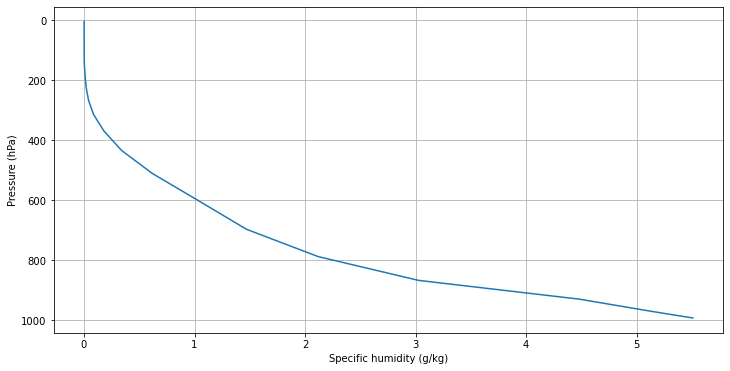

In [5]:
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air

plot_humidity(cesm_Q*1000., cesm_Q.lev)

In [39]:
def model_setup(Q, lev):
    """
    This is the model setup for both RRTMG_LW and RRTMG_SW
    
    Input:
        Q - (array) The specific humidity profile
        lev - (array) Elevation levels for Q
    Output:
        radmodel_LW - Longwave radiative model
        radmodel_SW - Shortwave radiative model
        
    """
    # Setting up the atmospheric temperatures within the column
    mystate = climlab.column_state(lev=lev, # These are the elevation levels. We'll be using CESM's elev. levels.
                               water_depth=2.5 
                              )

    # Setting up the longwave RRTMG
    radmodel_LW = climlab.radiation.RRTMG_LW(name='Longwave Radiation', # Model name
                              state=mystate,                         # Initial temperature conditions
                              specific_humidity=Q,            # Water vapor - coming from the CESM output
                              albedo = 0.25                          # Surface shortwave albedo
                                            )
    # Running the model
    radmodel_LW.compute_diagnostics()

    # Setting up the shortwave RRTMG
    radmodel_SW = climlab.radiation.RRTMG_SW(name='Shortwave Radiation', # Model name
                              state=mystate,                        # Initial temperature conditions
                              specific_humidity=Q,           # Water vapor - coming from the CESM output
                              albedo = 0.25                         # Surface shortwave albedo
                             )
    # Running the model
    radmodel_SW.compute_diagnostics()
    
    return radmodel_LW, radmodel_SW

In [40]:
rad_LW_cesm, rad_SW_cesm = model_setup(cesm_Q.values, cesm_Q.lev)

In [90]:
def plotting(radmodel_LW, radmodel_SW):
    fig = plt.figure(figsize=(20,6))
    ax1 = plt.subplot2grid((1,3), (0,0))
    ax2 = plt.subplot2grid((1,3), (0,1))

    ax1.plot(radmodel_LW.LW_flux_net, radmodel_LW.lev_bounds, label='LW')
    ax1.plot(radmodel_SW.SW_flux_net, radmodel_SW.lev_bounds, label='SW')
    ax1.invert_yaxis()
    #maxval = np.max((radmodel_LW.LW_flux_net[3:], radmodel_SW.SW_flux_net[3:]))
    #minval = np.min((radmodel_LW.LW_flux_net[3:], radmodel_SW.SW_flux_net[3:]))
    #ax1.set_xlim(minval-5, maxval+5)
    ax1.set_xlabel('Net Radiative Flux [W/m2]')
    ax1.set_ylabel('Pressure [mb]')
    ax1.legend()
    ax1.grid()

    ax2.plot(radmodel_LW.heating_rate['Tatm'], radmodel_LW.lev, label='LW')
    ax2.plot(radmodel_SW.heating_rate['Tatm'], radmodel_SW.lev, label='SW')
    ax2.invert_yaxis()
    maxval = np.max((radmodel_LW.heating_rate['Tatm'][3:], radmodel_SW.heating_rate['Tatm'][3:]))
    minval = np.min((radmodel_LW.heating_rate['Tatm'][3:], radmodel_SW.heating_rate['Tatm'][3:]))
    ax2.set_xlim(minval-1, maxval+1)
    ax2.set_xlabel('Heating Rate [deg/day]')
    ax2.set_ylabel('Pressure [mb]')
    ax2.legend()
    ax2.grid()

When we run the models, they output radiative flux and heating rates over the vertical.

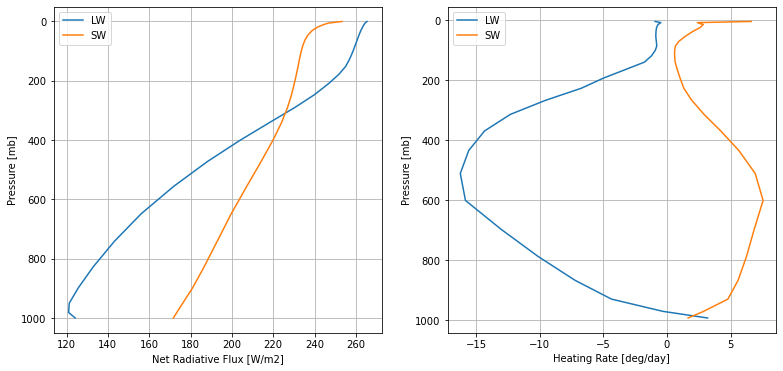

In [91]:
plotting(rad_LW_cesm, rad_SW_cesm)

# Loading Data from Observations

Next, we'll be loading humidity data from observations! We'll be using radiosonde data compiled by the University of Wyoming.

## San Diego

This is data provided by NKX San Diego.

In [10]:
q_sandiego = xr.open_dataset('Data/sd_q.nc')

In [51]:
q_sandiego

<xarray.Dataset>
Dimensions:  (lev: 124, q: 124)
Coordinates:
  * lev      (lev) float32 1e+03 998.0 995.0 985.0 974.0 ... 12.0 11.7 11.0 10.4
  * q        (q) float32 4.747 4.827 4.708 4.529 4.351 ... 0.02 0.02 0.02 0.02
Data variables:
    *empty*

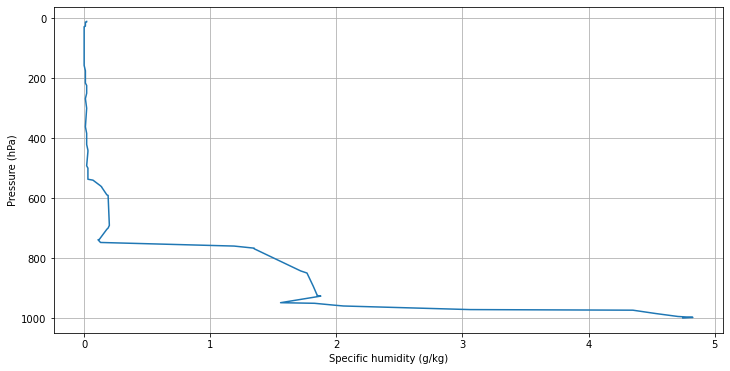

In [12]:
plot_humidity(q_sandiego.q, q_sandiego.lev)

In [72]:
rad_sandiego_LW, rad_sandiego_SW = model_setup(q_sandiego.q.values/1000, list(reversed(q_sandiego.lev.values)))

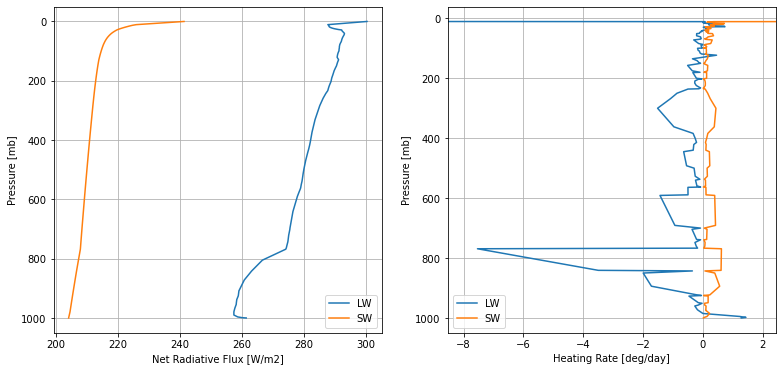

In [92]:
plotting(rad_sandiego_LW, rad_sandiego_SW)

## Lincoln

Radiosonde data from ILX, Lincoln.

In [75]:
q_lincoln = xr.open_dataset('Data/linil_q.nc')

In [76]:
q_lincoln

<xarray.Dataset>
Dimensions:  (lev: 128, q: 128)
Coordinates:
  * lev      (lev) float32 1e+03 995.0 989.0 978.0 970.0 ... 10.0 9.0 8.8 8.4
  * q        (q) float32 3.408 2.902 2.713 2.394 2.354 ... 0.04 0.04 0.04 0.05
Data variables:
    *empty*

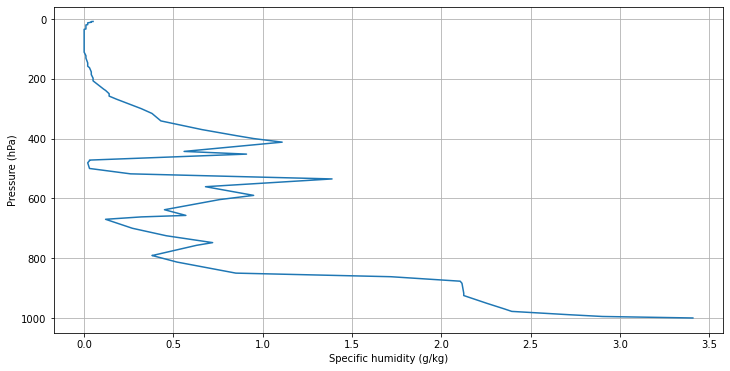

In [77]:
plot_humidity(q_lincoln.q, q_lincoln.lev)

In [78]:
rad_lincoln_LW, rad_lincoln_SW = model_setup(q_lincoln.q.values/1000, list(reversed(q_lincoln.lev.values)))

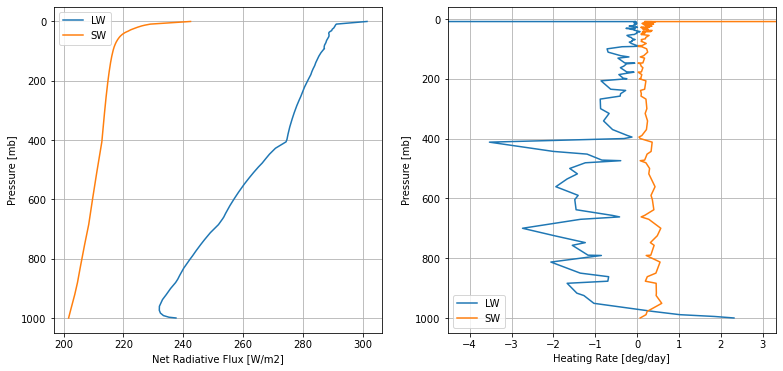

In [93]:
plotting(rad_lincoln_LW, rad_lincoln_SW)